## Pathway and Cell-Type Enrichment Analysis of Fetal-specific eGenes

In [99]:
options(stringsAsFactors = F)
setwd("~/Github/Fetal_metaQTL/")

library(tidyverse)
#BiocManager::install('gprofiler2')
library(gprofiler2)
library(openxlsx)

source("code/06-analyses/fisher_overlap.R")

1. Load data from Table S1

In [100]:
tableS1 = openxlsx::read.xlsx("data/manuscript/ST1.xlsx",sheet="ST1-2-eGene")
dim(tableS1)
fetal_only_eGenes = tableS1 %>% filter(fetal_only=="yes") %>% select(pid, gene_name, gene_type, qval) %>% as_tibble()
fetal_all_eGenes = tableS1 %>% select(pid) %>% pull()
head(fetal_only_eGenes)
dim(fetal_only_eGenes)

[1] 10094    17

pid,gene_name,gene_type,qval
<chr>,<chr>,<chr>,<dbl>
ENSG00000000419,DPM1,protein_coding,0.00147123
ENSG00000002746,HECW1,protein_coding,0.00100023
ENSG00000004478,FKBP4,protein_coding,0.01215830
ENSG00000005812,FBXL3,protein_coding,0.04243070
ENSG00000006025,OSBPL7,protein_coding,0.02392810
ENSG00000006062,MAP3K14,protein_coding,0.01218350


[1] 2488    4

### Pathway Analysis of Fetal-only eGenes using gProfileR2

In [101]:
library(gprofiler2)

## Pathway analysis with gProfileR
## Note: ordered query here because genes are ranked by DTU significance. Usually this will be F
## Always use the matching background gene set
path = gprofiler2::gost(query=fetal_only_eGenes$pid,correction_method = 'fdr',
                        custom_bg = fetal_all_eGenes,source=c("GO", "KEGG", "REACTOME"))


Detected custom background input, domain scope is set to 'custom'



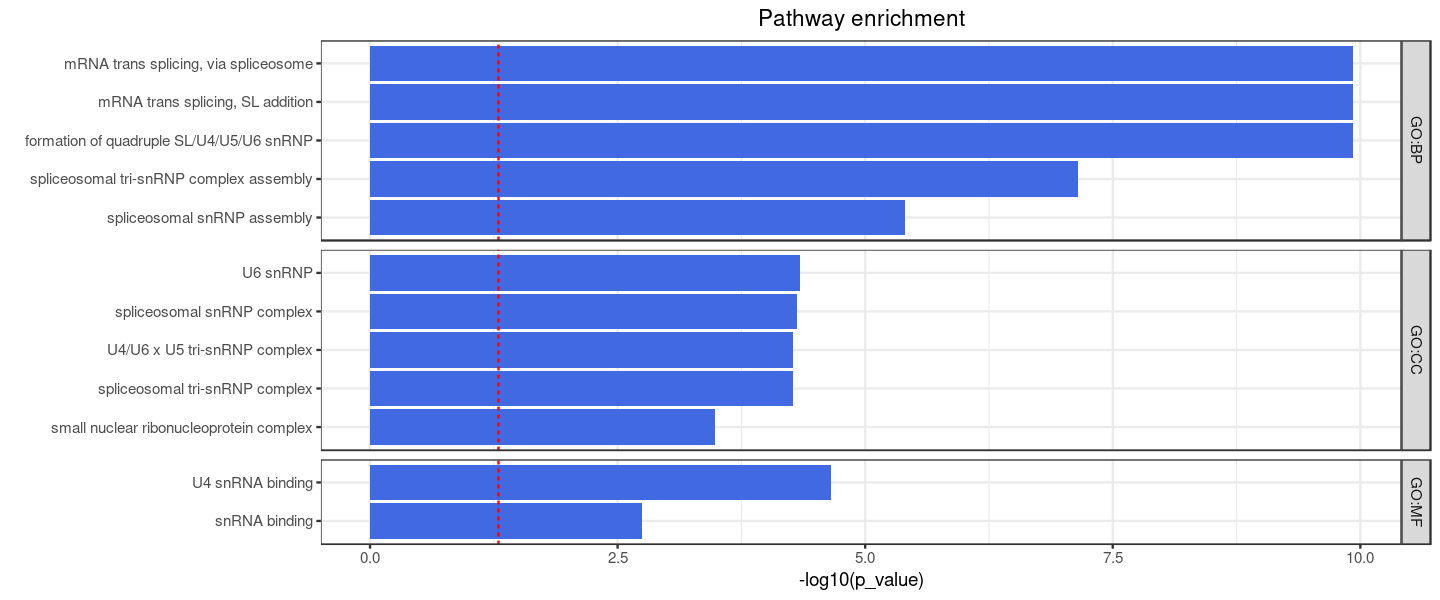

In [102]:
df_path = as_tibble(path$result)

## Plot top 5 results per database
panelA <- df_path %>% group_by(source) %>% slice_min(p_value,n=5) %>% ungroup() %>%
  ggplot(aes(x=reorder(term_name, -p_value), y=-log10(p_value), fill=source)) + geom_bar(stat='identity',fill='royalblue') + coord_flip() + theme_bw() + labs(x="")  + 
  facet_grid(source~., space = 'free', scales='free') + theme(legend.position = 'none') + 
geom_hline(yintercept = -log10(0.05), lty=2,color='red') + ggtitle("Pathway enrichment") + theme(plot.title = element_text(hjust=.5))
panelA


In [103]:
df_path %>% arrange(p_value) %>% head()

query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents
<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000353,GO:BP,formation of quadruple SL/U4/U5/U6 snRNP,9958,147,"GO:0022618, GO:0045291"
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0000365,GO:BP,"mRNA trans splicing, via spliceosome",9958,149,GO:0000398
query_1,TRUE,1.210070e-10,27,2389,25,0.010464630,0.9259259,GO:0045291,GO:BP,"mRNA trans splicing, SL addition",9958,13184,GO:0000365
query_1,TRUE,7.226205e-08,35,2389,27,0.011301800,0.7714286,GO:0000244,GO:BP,spliceosomal tri-snRNP complex assembly,9958,110,GO:0000387
query_1,TRUE,4.047260e-06,46,2389,30,0.012557555,0.6521739,GO:0000387,GO:BP,spliceosomal snRNP assembly,9958,161,"GO:0000398, GO:0022618"
query_1,TRUE,2.264497e-05,24,2389,19,0.007953118,0.7916667,GO:0030621,GO:MF,U4 snRNA binding,9958,4916,GO:0017069


### Cell-Type Enrichment: Broad Clusters

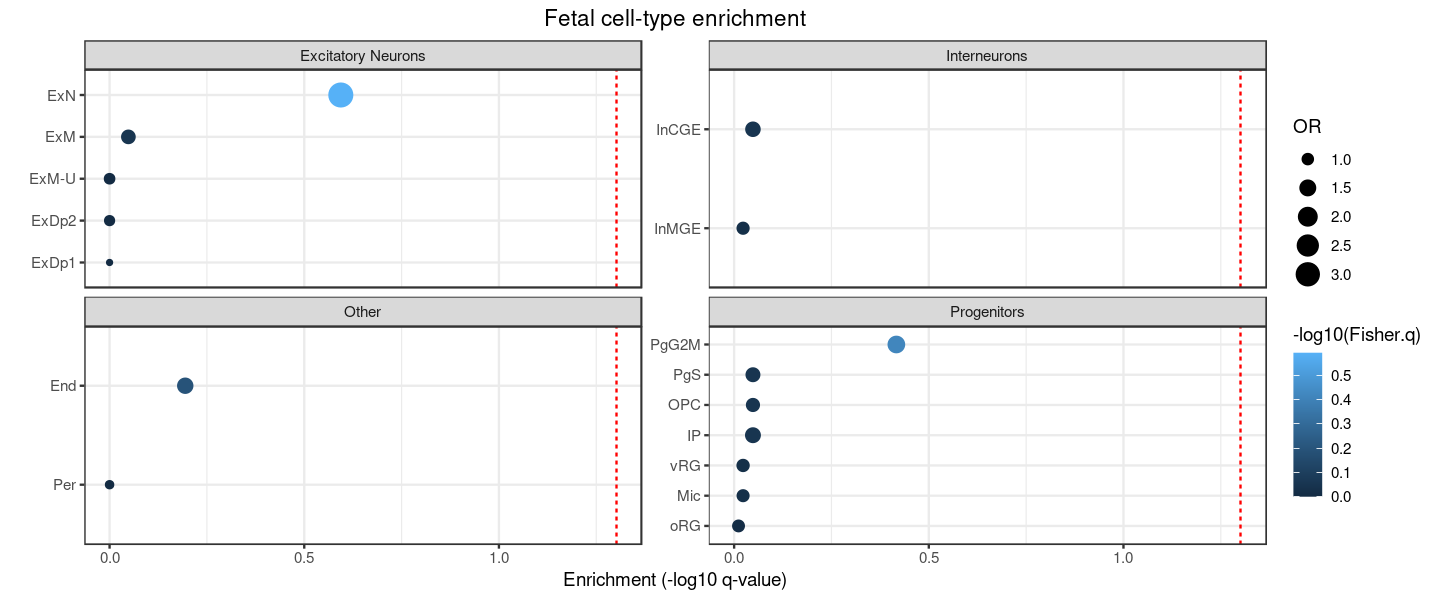

In [104]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl, celltypemarkers.tableS5$Ensembl))


  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers$Cluster)) {
    marker_genes = celltypemarkers %>% filter(Cluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(fetal_only_eGenes$pid, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Fetal-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  df_fisher$Fisher.q[df_fisher$OR<1] = 1
    df_fisher$Fisher.p[df_fisher$OR<1] = 1

  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = -log10(0.05),lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))

  

### Cell-Type Enrichment: Narrow Clusters

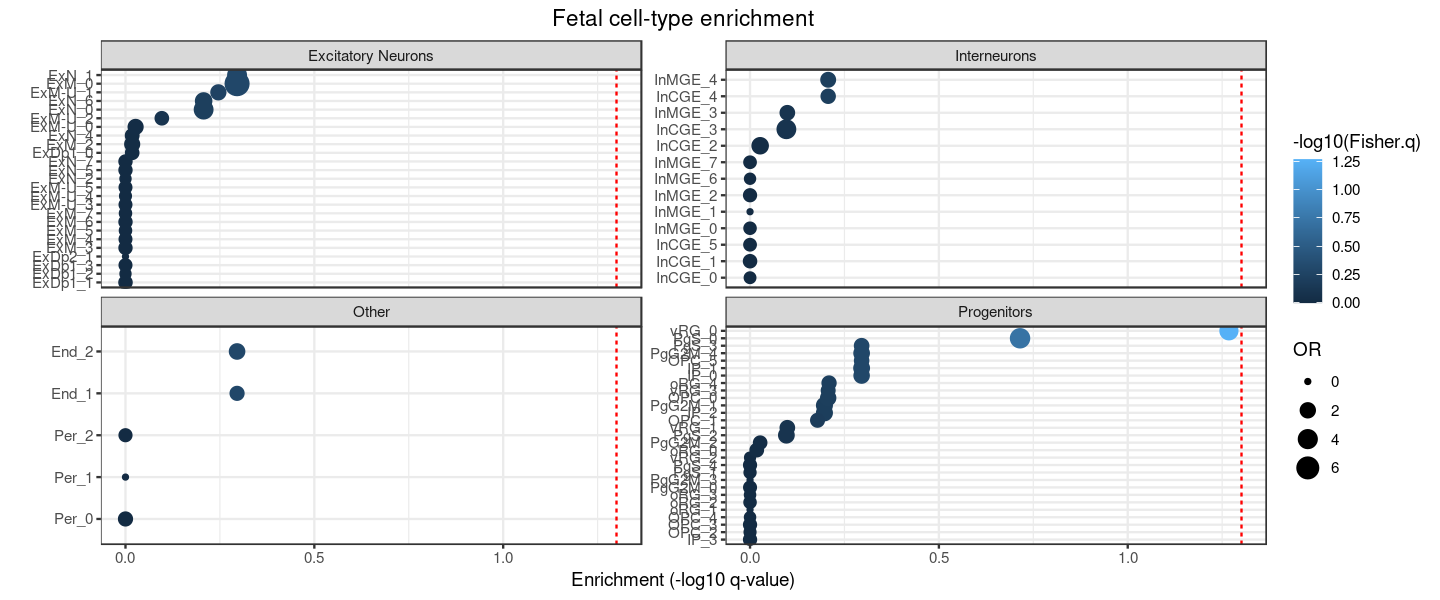

In [105]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl, celltypemarkers.tableS5$Ensembl))

  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers.tableS5$Subcluster)) {
    marker_genes = celltypemarkers.tableS5 %>% filter(Subcluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(fetal_only_eGenes$pid, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Fetal-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))
  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  df_fisher$Fisher.q[df_fisher$OR<1] = 1
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
panelB <- ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), size=OR, color=-log10(Fisher.q))) +
        geom_point() + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = -log10(.05),lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))
panelB
  

In [106]:
df_fisher %>% arrange(Fisher.q)

set,cell,OR,Fisher.p,X.95.CI,X.95.CI.1,Overlap,Reference.List,Input.List,Background,X..List.Overlap,Fisher.q,CellClass
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
Fetal-only-eGenes,vRG_0,3.432432,0.0007495089,1.61658953893641,6.91038195466242,13,43,222,1909,30.2,0.05396464,Progenitors
Fetal-only-eGenes,PgS_0,4.187785,0.0053556915,1.39860291006989,11.4402021488856,7,20,222,1909,35,0.19280490,Progenitors
Fetal-only-eGenes,PgS_3,1.700116,0.0603238144,0.95662835212887,2.88699296801838,19,107,222,1909,17.8,0.50649934,Progenitors
Fetal-only-eGenes,PgG2M_4,2.136178,0.0670987011,0.832833789883545,4.86752965870252,8,37,222,1909,21.6,0.50649934,Progenitors
Fetal-only-eGenes,IP_0,2.063799,0.0742342506,0.806812148904564,4.68331930931602,8,38,222,1909,21.1,0.50649934,Progenitors
Fetal-only-eGenes,IP_1,2.225181,0.0333261022,0.96830290801284,4.67398407441351,10,45,222,1909,22.2,0.50649934,Progenitors
Fetal-only-eGenes,ExN_1,3.859376,0.0229138658,1.02535707420352,12.5334458751358,5,15,222,1909,33.3,0.50649934,Excitatory Neurons
Fetal-only-eGenes,ExM_0,7.643962,0.0689229236,0.551534689810141,105.971588825128,2,4,222,1909,50,0.50649934,Excitatory Neurons
Fetal-only-eGenes,OPC_5,1.657538,0.0551612530,0.960910681824055,2.74526942860321,21,121,222,1909,17.4,0.50649934,Progenitors


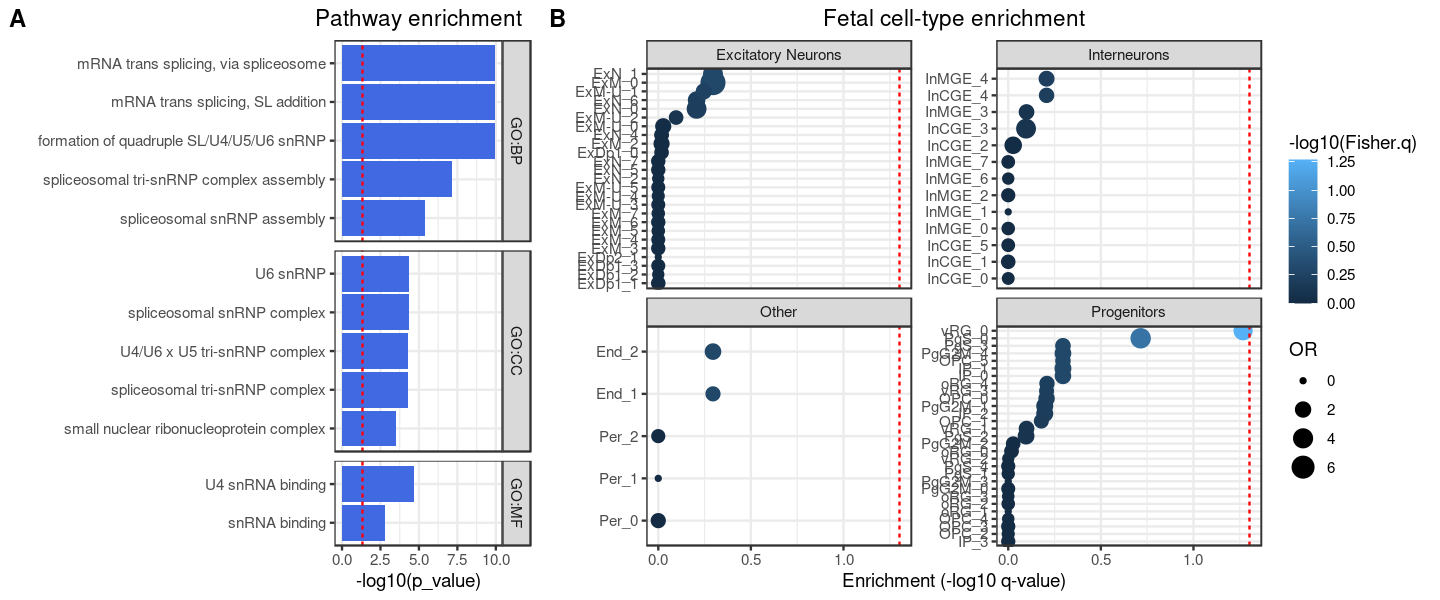

In [107]:
options(repr.plot.width=12, repr.plot.height=5)
cowplot::plot_grid(plotlist = list(panelA, panelB),labels="AUTO",rel_widths = c(.6,1))

## Part2. Compare Fetal-only-eGenes with Tri1 and Tri2 specific eGenes
### Load Tri1 and Tri2 supplementary data

In [108]:
tableS3.tri1 = openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-1-tri1-eGene") %>% as_tibble()
tableS3.tri1 %>% head()

#4211 tri1 egenes
nrow(tableS3.tri1)


pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000460,6010,1.02748,515.262,91.0303,chr1:169823752,161648,1.87528e-08,-0.338308,9.999e-05,4.91993e-05,4.91144e-04,3.09666e-05
ENSG00000001460,3692,1.04347,626.503,93.7763,rs760969,2280,8.49670e-12,-0.398405,9.999e-05,2.13673e-08,4.57817e-07,2.73383e-05
ENSG00000002016,5008,1.04250,822.961,93.8064,rs2887532,-47724,5.00270e-09,-0.476405,9.999e-05,1.23554e-05,1.44921e-04,2.07242e-05
ENSG00000002549,4608,1.02306,669.967,95.8886,rs10019460,107522,3.33719e-12,-0.485063,9.999e-05,8.09149e-09,1.84090e-07,2.33459e-05
ENSG00000003509,5953,1.02392,880.264,93.4142,rs1158219,88046,4.19471e-09,0.441495,9.999e-05,1.48403e-05,1.70099e-04,1.78380e-05
ENSG00000004534,2064,1.02570,146.024,89.9238,rs1403180440,15338,1.85048e-15,0.363467,9.999e-05,8.49570e-12,3.34591e-10,1.08386e-04


[1] 4211

In [109]:
tableS3.tri2 = openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-2-tri2-eGene") %>% as_tibble()
tableS3.tri2 %>% head()

#2220 tri2 egenes
nrow(tableS3.tri2)

pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000460,6010,1.04653,384.512,101.815,chr1:169823752,161648,9.96853e-09,-0.389951,0.00009999,2.11583e-05,4.70499e-04,2.15440e-05
ENSG00000001460,3692,1.05619,467.377,103.335,rs10903084,3761,1.23423e-15,-0.782329,0.00009999,6.48869e-12,5.56236e-10,1.86000e-05
ENSG00000001630,3216,1.05840,330.091,103.495,rs192531200,-531093,4.23111e-07,-1.766910,0.00019998,4.13634e-04,6.00989e-03,2.66240e-05
ENSG00000002016,5008,1.04679,748.901,106.225,rs12812346,-31035,5.51205e-08,-0.552818,0.00019998,1.10430e-04,1.96400e-03,1.10763e-05
ENSG00000002822,6246,1.03623,831.830,106.168,chr7:3064571,831327,8.78419e-07,-0.572421,0.00149985,1.85745e-03,1.97064e-02,9.45131e-06
ENSG00000003509,5953,1.06228,622.213,101.701,rs1056021,21475,1.16466e-06,0.362884,0.00189981,2.49890e-03,2.50985e-02,1.43969e-05


[1] 2220

In [116]:
#1261 tri1-tri2 shared eGenes
length(intersect(tableS3.tri1$pid, tableS3.tri2$pid))

## No overlap (under enrichment in fact)
ORA(fetal_only_eGenes$pid, tableS3.tri1$pid, fetal_all_eGenes, fetal_all_eGenes)

ORA(fetal_only_eGenes$pid, tableS3.tri2$pid, fetal_all_eGenes, fetal_all_eGenes)

[1] 1261

OR               Fisher p                 -95%CI 
   "0.541554618379489" "4.08827237709864e-31"    "0.485651205087775" 
                +95%CI                Overlap         Reference List 
   "0.603251717368026"                  "533"                 "3080" 
            Input List             Background         % List Overlap 
                "2488"                "10094"                 "17.3"

OR               Fisher p                 -95%CI 
   "0.486062037931035" "8.10614848022926e-27"    "0.421071624652551" 
                +95%CI                Overlap         Reference List 
    "0.55948304555766"                  "264"                 "1757" 
            Input List             Background         % List Overlap 
                "2488"                "10094"                   "15"

### Pathway Analysis of Tri1-only eGenes

In [111]:
tri1_only = tableS3.tri1$pid[!tableS3.tri1$pid %in% tableS3.tri2$pid]
length(tri1_only)
path = gprofiler2::gost(query=tri1_only,correction_method = 'fdr',
                        custom_bg = fetal_all_eGenes,source=c("GO", "KEGG", "REACTOME"))
                        
path ## No enrichments found



[1] 2950

Detected custom background input, domain scope is set to 'custom'

No results to show
Please make sure that the organism is correct or set significant = FALSE



NULL

### Pathway Analysis of Tri2-only eGenes

In [113]:
tri2_only = tableS3.tri2$pid[!tableS3.tri2$pid %in% tableS3.tri1$pid]
length(tri2_only)
path = gprofiler2::gost(query=tri2_only,correction_method = 'fdr',
                        custom_bg = fetal_all_eGenes,source=c("GO", "KEGG", "REACTOME"))
                        
df_path = as_tibble(path$result)
path ## No enrichments found


[1] 959

Detected custom background input, domain scope is set to 'custom'

No results to show
Please make sure that the organism is correct or set significant = FALSE



NULL

### Cell type enrichment Analysis of Tri1 and Tri2-only eGenes (broad)

[1] 2950

[1] 959

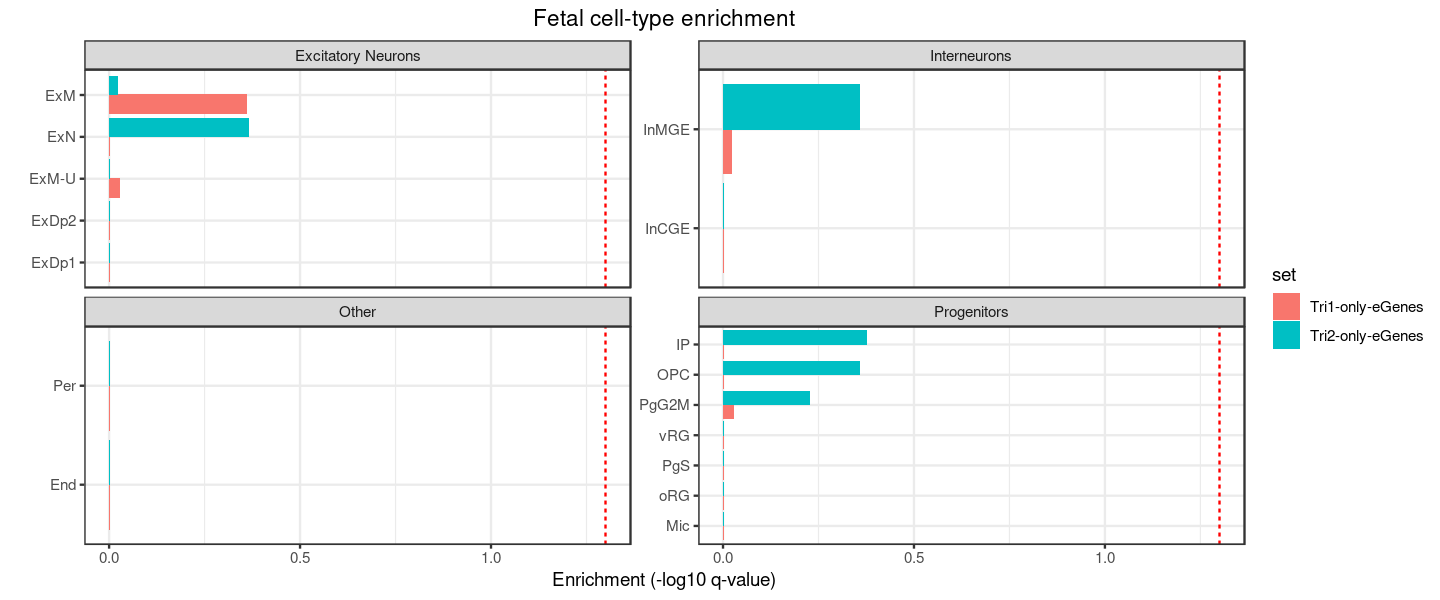

In [117]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl, celltypemarkers.tableS5$Ensembl))

length(tri1_only)
length(tri2_only)

  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers$Cluster)) {
    marker_genes = celltypemarkers %>% filter(Cluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(tri1_only, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri1-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))

      enrichment2 = ORA(tri2_only, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri2-only-eGenes", cell=this_cell, as.data.frame(t(enrichment2))))

  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  df_fisher$Fisher.q[df_fisher$OR<1] = 1
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), fill=set)) +
        geom_bar(stat='identity', position=position_dodge()) + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = -log10(.05),lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))

  

### Cell type enrichment Analysis of Tri1 and Tri2-only eGenes (narrow)

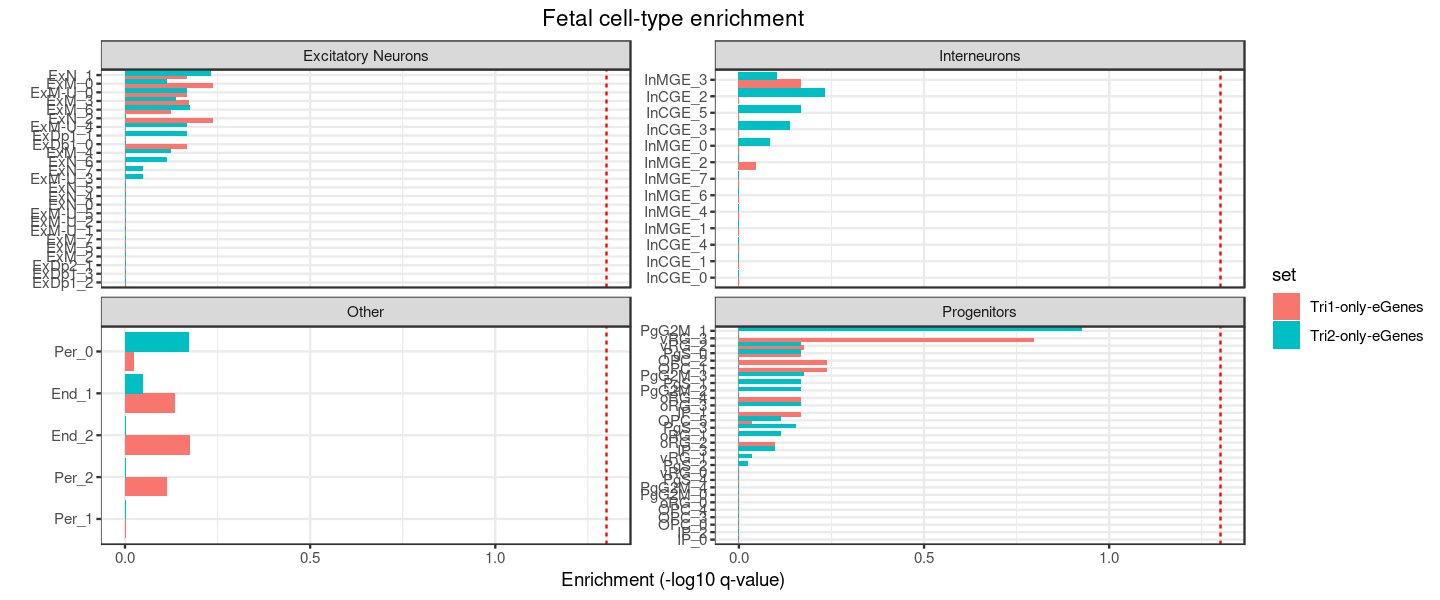

In [115]:
# Cell type markers from fetal brain scRNAseq
# Load poliodakis et al markers (Table S4)
celltypemarkers <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers.tableS5 = openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/ec1863fa-0dfc-405c-928c-c5ca96115667/mmc6', sheet='Sub-cluster enriched genes') %>% as_tibble()
markers.bg = unique(c(celltypemarkers$Ensembl, celltypemarkers.tableS5$Ensembl))


  df_fisher = data.frame()
  for(this_cell in unique(celltypemarkers.tableS5$Subcluster)) {
    marker_genes = celltypemarkers.tableS5 %>% filter(Subcluster == this_cell) %>% dplyr::select(Ensembl) %>% pull()
    enrichment = ORA(tri1_only, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri1-only-eGenes", cell=this_cell, as.data.frame(t(enrichment))))

      enrichment2 = ORA(tri2_only, marker_genes, fetal_all_eGenes, markers.bg)
    df_fisher = rbind(df_fisher, data.frame(set="Tri2-only-eGenes", cell=this_cell, as.data.frame(t(enrichment2))))

  }

    df_fisher$OR = as.numeric(df_fisher$OR)
  df_fisher$Fisher.p = as.numeric(df_fisher$Fisher.p)
  df_fisher$Fisher.q = p.adjust(df_fisher$Fisher.p,'fdr')
  df_fisher$Fisher.q[df_fisher$OR<1] = 1
  
  df_fisher$CellClass = "Progenitors"
  df_fisher$CellClass[grep("Ex",df_fisher$cell)] = "Excitatory Neurons"
  df_fisher$CellClass[grep("In",df_fisher$cell)] = "Interneurons"
  df_fisher$CellClass[grep("End",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  df_fisher$CellClass[grep("Per",df_fisher$cell)] = "Other"
  
ggplot(df_fisher,aes(x=reorder(cell, -Fisher.q), y= -log10(Fisher.q), fill=set)) +
        geom_bar(stat='identity', position=position_dodge()) + coord_flip() + facet_wrap(~CellClass, scales = 'free_y') + theme_bw() +
    geom_hline(yintercept = -log10(.05),lty=2,color='red') + labs(y='Enrichment (-log10 q-value)',x='') + 
ggtitle("Fetal cell-type enrichment")+ theme(plot.title = element_text(hjust=.5))
